In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import pandas as pd
import os 
from pathlib import Path
import cv2
import threading
from scipy.ndimage import binary_fill_holes

In [2]:
old_dir = './FishImgDataset'
resized_dir = './resized-dataset'

labels = ['Glass Perchlet', 'Gold Fish',
          'Gourami', 'Jaguar Gapote', 'Mosquito Fish']

def setup_dir(labelName):
    # Path(resized_dir).mkdir(parents=True,exist_ok=True)
    # Path(f"{resized_dir}/train").mkdir(parents=True,exist_ok=True)
    # Path(f"{resized_dir}/val").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/test/{labelName}").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/train/{labelName}").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/val/{labelName}").mkdir(parents=True,exist_ok=True)

for label in labels:
    setup_dir(label)


In [3]:

def importImages(path):
    images = []
    folder_path = path
    nama_files = os.listdir(folder_path)
    for nama_file in nama_files:
        # print(nama_file.split('.')[1])
        if nama_file.split('.')[1] != 'gif':
            file_path = os.path.join(folder_path, nama_file)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            images.append(image)
    return images

In [4]:
def resizeImage(image):
    size = 100
    result = cv2.resize(image,(size,size))
    return result

In [5]:
def prepare_image(labelName,typename):
    images = importImages(f"{old_dir}/{typename}/{labelName}")
    for index, image in enumerate(images):
        try:
            res = resizeImage(image)
            filename = f"img{index}.png"
            plt.imsave(f"{resized_dir}/{typename}/{labelName}/{filename}",res)
        except Exception as e:
            errs.append(f"file: {typename}/{labelName}/{filename} , error: {e}")


In [6]:
from tqdm import tqdm
import threading
dirs = labels
errs = []
# prepare_image(labels[0],'train')
for label in tqdm(dirs):
    t1 = threading.Thread(target=prepare_image,args=(label,'train'))
    t2 = threading.Thread(target=prepare_image,args=(label,'val'))
    t3 = threading.Thread(target=prepare_image,args=(label,'test'))
    t1.start()
    t2.start()
    t3.start()
    t1.join()
    t2.join()
    t3.join()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


In [7]:
print(errs)

[]


# Masking

In [74]:
from scipy.ndimage import binary_fill_holes
s1 = cv2.imread('./resized-dataset/train/Glass Perchlet/img0.png')
s2 = cv2.imread('./resized-dataset/train/Gold Fish/img0.png')
s3 = cv2.imread('./resized-dataset/train/Gourami/img0.png')
s4 = cv2.imread('./resized-dataset/train/Jaguar Gapote/img0.png')
s5 = cv2.imread('./resized-dataset/train/Mosquito Fish/img0.png')
sources = [s1,s2,s3,s4,s5]

In [75]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  for i in range(len(img)):
    plt.subplot(1, len(img), i+1)
    plt.imshow(img[i], cmap='gray')

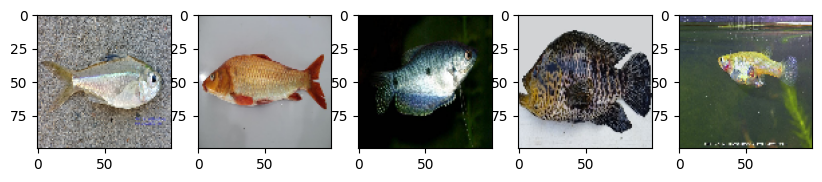

In [76]:
show_img(sources)

75.84437499999999


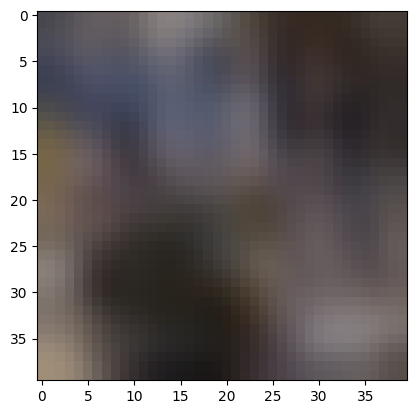

In [77]:
center = sources[3][30:70, 30:70]
center = cv2.GaussianBlur(center,(11,11),0)
# center =cv2.cvtColor(center)
plt.imshow(center,'gray')
print(center.mean(0).mean(0).mean(0))

In [12]:
def median_filter(src: np.ndarray, size=3):
    src_pad = np.pad(src, (size-1)//2, "constant")
    x_axis, y_axis = src.shape
    result = np.zeros_like(src)
    for y in range(y_axis):
        for x in range(x_axis):
            m33 = src_pad[x : x + size, y : y + size]
            flat = np.sort(m33.flatten())
            result[x, y] = flat[(flat.size+1)//2]
    return result

In [13]:
def mask_fish(image):
    # Preprocess
    
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #center image
    center = src[30:70, 30:70]
    center = cv2.GaussianBlur(center,(11,11),0)
    
    #overral image
    #gaussian blur
    src = cv2.GaussianBlur(src,(7,7),0)
    #median filter
    src = median_filter(src,5)

    mean = np.mean(src)
    mean_center = np.mean(center)
    print(f"all: {mean}, center: {mean_center}")

    # Thresholding based on background color
    if mean < mean_center:
        # if avg color is black
        _, mask = cv2.threshold(src, mean, 255, cv2.THRESH_BINARY)
    else:
        _, mask = cv2.threshold(src, mean+10, 255, cv2.THRESH_BINARY_INV)
    #opening
    mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,np.ones([3,3]))
    mask = binary_fill_holes(mask).astype(np.uint8)
    # mask = np.stack([mask,mask,mask],2)
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    return masked_image

all: 140.5962, center: 161.09
all: 149.6268, center: 129.39875
all: 40.204, center: 144.985625
all: 135.4248, center: 74.405
all: 86.1567, center: 113.645


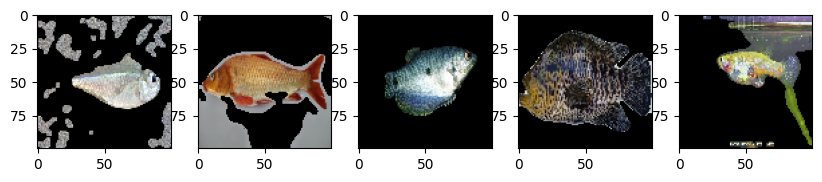

In [14]:
res = []
for item in sources:
    res.append(mask_fish(item))
show_img(res)

In [105]:
# def contrast(image):
#     hist = cv2.calcHist([image], [0], None, [256], [0, 256])
#     hist_norm = hist / hist.sum()
#     contrast_value = np.sum(hist_norm * np.square(np.arange(256)))
#     return contrast_value
def contrast(image):
    result = 0
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            result += pow(j - k, 2) * image[j, k]
    return result

def homogeneity(image):
    result = 0
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            result += image[j, k] / (1 + abs(j - k))
    return result

def dissimilarity(image):
    result = 0
    for j in range(image.shape[0]):
        for k in range(image.shape[1]):
            result += abs(j - k) * image[j, k]
    return result

def entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist /= hist.sum()
    entropy = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
    return entropy

def asm(image):
    result = np.sum(np.square(image))
    return result

def energy(image):
    result = np.sqrt(asm(image))
    return result

def correlation(image):
    mean = np.mean(image)
    std = np.std(image)
    image = (image - mean) / std
    result = np.mean(image)
    return result


In [110]:
folders = {
    'perchlet': './resized-dataset/train/Glass Perchlet/',
    'gold': './resized-dataset/train/Gold Fish/',
    'gourami': './resized-dataset/train/Gourami/',
    'jaguar': './resized-dataset/train/Jaguar Gapote/',
    'mosquito': './resized-dataset/train/Mosquito Fish/'
}

data = {}


for key, path in folders.items():
    images = importImages(path)
    masked_images = []
    contrast_values = []
    homogeneity_values = []
    dissimilarity_values = []
    entropy_values = []
    asm_values = []
    energy_values = []
    correlation_values = []
    for image in images:
        masked_image = mask_fish(image)
        if masked_image is not None:
            masked_image_grayscale = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
            masked_images.append(masked_image_grayscale)
            contrast_value = contrast(masked_image_grayscale)
            contrast_values.append(contrast_value)
            homogeneity_value = homogeneity(masked_image_grayscale)
            homogeneity_values.append(homogeneity_value)
            dissimilarity_value = dissimilarity(masked_image_grayscale)
            dissimilarity_values.append(dissimilarity_value)
            entropy_value = entropy(masked_image_grayscale)
            entropy_values.append(entropy_value)
            asm_value = asm(masked_image_grayscale)
            asm_values.append(asm_value)
            energy_value = energy(masked_image_grayscale)
            energy_values.append(energy_value)
            correlation_value = correlation(masked_image_grayscale)
            correlation_values.append(correlation_value)
    data[key] = {
        'images': masked_images,
        'contrast': contrast_values,
        'homogeneity': homogeneity_values,
        'dissimilarity': dissimilarity_values,
        'entropy': entropy_values,
        'asm': asm_values,
        'energy': energy_values,
        'correlation': correlation_values
    }

all: 140.5962, center: 161.09
all: 170.1173, center: 164.55375


C:\Users\hp14s\AppData\Local\Temp\ipykernel_19656\2693438865.py:10: RuntimeWarning: overflow encountered in long_scalars
  result += pow(j - k, 2) * image[j, k]


all: 205.8037, center: 135.94125
all: 80.2419, center: 95.84375
all: 76.824, center: 97.089375
all: 95.8175, center: 114.990625
all: 59.0677, center: 77.15
all: 97.3055, center: 110.1825
all: 93.5763, center: 86.795625
all: 127.6461, center: 118.22625
all: 96.5513, center: 84.544375
all: 105.5761, center: 93.828125
all: 101.0169, center: 91.97375
all: 65.8249, center: 104.426875
all: 99.3505, center: 92.67375
all: 87.4141, center: 79.033125
all: 57.619, center: 45.414375
all: 106.062, center: 90.8025
all: 89.5196, center: 68.0925
all: 126.0963, center: 109.36625
all: 81.0589, center: 70.63375
all: 121.6312, center: 103.081875
all: 102.0653, center: 89.665625
all: 119.5813, center: 101.485
all: 215.0255, center: 155.234375
all: 79.6767, center: 73.780625
all: 69.8927, center: 63.351875
all: 64.2276, center: 59.190625
all: 59.805, center: 52.65625
all: 78.3473, center: 82.110625
all: 112.0063, center: 113.97875
all: 64.692, center: 53.973125
all: 105.1936, center: 109.8325
all: 63.5978, 

In [111]:
# df = pd.DataFrame(data)
# df.to_csv('hasil_perhitungan.csv', index=False)

output_file = 'results.csv'
output_data = []
for key, value in data.items():
    for i, image in enumerate(value['images']):
        contrast_value = value['contrast'][i]
        homogeneity_value = value['homogeneity'][i]
        dissimilarity_value = value['dissimilarity'][i]
        entropy_value = value['entropy'][i]
        asm_value = value['asm'][i]
        energy_value = value['energy'][i]
        correlation_value = value['correlation'][i]
        output_data.append({
            'Fish Type': key,
            'Image Index': i+1,
            'Contrast': contrast_value,
            'Homogeneity': homogeneity_value,
            'Dissimilarity': dissimilarity_value,
            'Entropy': entropy_value,
            'ASM': asm_value,
            'Energy': energy_value,
            'Correlation': correlation_value
        })

df = pd.DataFrame(output_data)
df.to_csv(output_file, index=False)
print(f"Data hasil masking disimpan dalam file '{output_file}'.")

Data hasil masking disimpan dalam file 'results.csv'.


In [101]:
# for key, value in data.items():
#     print(f"Citra {key}:")
#     for i, image in enumerate(value['images']):
#         contrast_value = value['contrast'][i]
#         print(f"  - Image {i+1}: Contrast = {contrast_value}")

Citra perchlet:
  - Image 1: Contrast = 5559680.116137681
  - Image 2: Contrast = 5559680.074755289
  - Image 3: Contrast = 5559680.137941306
  - Image 4: Contrast = 5559680.055338331
  - Image 5: Contrast = 5559679.920188212
  - Image 6: Contrast = 5559679.916021656
  - Image 7: Contrast = 5559679.926296463
  - Image 8: Contrast = 5559680.022734022
  - Image 9: Contrast = 5559680.0255656615
  - Image 10: Contrast = 5559679.944418957
  - Image 11: Contrast = 5559680.041058776
  - Image 12: Contrast = 5559680.000242712
  - Image 13: Contrast = 5559680.024271198
  - Image 14: Contrast = 5559679.910560637
  - Image 15: Contrast = 5559679.972411739
  - Image 16: Contrast = 5559680.0664221775
  - Image 17: Contrast = 5559679.939079294
  - Image 18: Contrast = 5559679.972007219
  - Image 19: Contrast = 5559679.96169196
  - Image 20: Contrast = 5559680.060718446
  - Image 21: Contrast = 5559680.060637542
  - Image 22: Contrast = 5559680.084423316
  - Image 23: Contrast = 5559680.040613804
  -

In [98]:
# folders = {
#     'perchlet': './resized-dataset/train/Glass Perchlet/',
#     'gold': './resized-dataset/train/Gold Fish/',
#     'gourami': './resized-dataset/train/Gourami/',
#     'jaguar': './resized-dataset/train/Jaguar Gapote/',
#     'mosquito': './resized-dataset/train/Mosquito Fish/'
# }

# data = {}

# for key, path in folders.items():
#     images = importImages(path)
#     masked_images = []
#     for image in images:
#         masked_image = mask_fish(image)
#         masked_images.append(masked_image)
#     data[key] = masked_images

# folders = {
#     'perchlet': './resized-dataset/train/Glass Perchlet/',
#     'gold': './resized-dataset/train/Gold Fish/',
#     'gourami': './resized-dataset/train/Gourami/',
#     'jaguar': './resized-dataset/train/Jaguar Gapote/',
#     'mosquito': './resized-dataset/train/Mosquito Fish/'
# }

# data = {}

# for key, path in folders.items():
#     images = importImages(path)
#     masked_images = []
#     for image in images:
#         masked_image = mask_fish(image)
#         masked_image_grayscale = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
#         masked_images.append(masked_image_grayscale)
#     data[key] = masked_images

all: 140.5962, center: 161.09
all: 170.1173, center: 164.55375
all: 205.8037, center: 135.94125
all: 80.2419, center: 95.84375
all: 76.824, center: 97.089375
all: 95.8175, center: 114.990625
all: 59.0677, center: 77.15
all: 97.3055, center: 110.1825
all: 93.5763, center: 86.795625
all: 127.6461, center: 118.22625
all: 96.5513, center: 84.544375
all: 105.5761, center: 93.828125
all: 101.0169, center: 91.97375
all: 65.8249, center: 104.426875
all: 99.3505, center: 92.67375
all: 87.4141, center: 79.033125
all: 57.619, center: 45.414375
all: 106.062, center: 90.8025
all: 89.5196, center: 68.0925
all: 126.0963, center: 109.36625
all: 81.0589, center: 70.63375
all: 121.6312, center: 103.081875
all: 102.0653, center: 89.665625
all: 119.5813, center: 101.485
all: 215.0255, center: 155.234375
all: 79.6767, center: 73.780625
all: 69.8927, center: 63.351875
all: 64.2276, center: 59.190625
all: 59.805, center: 52.65625
all: 78.3473, center: 82.110625
all: 112.0063, center: 113.97875
all: 64.692, c

In [96]:
# folders = [
#     './resized-dataset/train/Glass Perchlet/',
#     './resized-dataset/train/Gold Fish/',
#     './resized-dataset/train/Gourami/',
#     './resized-dataset/train/Jaguar Gapote/',
#     './resized-dataset/train/Mosquito Fish/',
#     ]
# data = []
# file_name=[]
# for folder in folders:
#     dataset = os.listdir(folder)
#     for file in dataset:
#         img_path = os.path.join(folder, file)
#         name = os.path.splitext(file)[0]
#         temp = cv2.imread(img_path)
#         gray_img = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY)
#         data.append(gray_img)
#         file_name.append(name)

In [94]:
# dataset2=[]
# for i in range(len(dataset)):
#     dataset2.append(dataset[i])

In [33]:
# from PIL import Image

# def grayscale_img(image):
#     # Mengubah citra menjadi grayscale
#     pil_image = Image.fromarray(image)
#     grayscale_image = pil_image.convert("L")
#     return grayscale_image


In [37]:
# def cooccurrance(image, angle):
#     # Menghitung matriks co-occurrence dengan sudut tertentu
#     image = np.array(image)
#     height, width = image.shape
#     result = np.zeros((256, 256), dtype=int)

#     if angle == 0:
#         dx, dy = 1, 0
#     elif angle == 45:
#         dx, dy = 1, -1
#     elif angle == 90:
#         dx, dy = 0, -1
#     elif angle == 135:
#         dx, dy = -1, -1
#     else:
#         raise ValueError("Sudut yang valid adalah 0, 45, 90, atau 135.")

#     for j in range(height):
#         for k in range(width):
#             if j-dx >= 0 and k-dy >= 0 and j+dx < height and k+dy < width:
#                 result[image[j, k], image[j+dx, k+dy]] += 1

#     return result

all: 140.5962, center: 161.09
all: 149.6268, center: 129.39875
all: 40.204, center: 144.985625
all: 135.4248, center: 74.405
all: 86.1567, center: 113.645


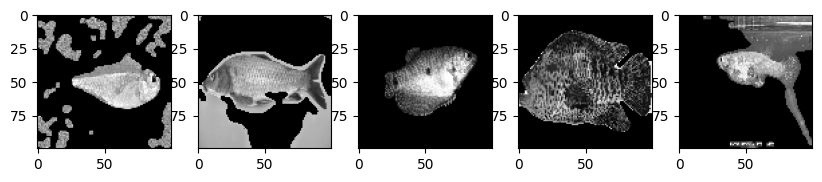

In [38]:
# res_grey = []
# for item in sources:
#     res_grey.append(grayscale_img(mask_fish(item)))

# show_img(res_grey)

In [39]:
# resCo0 = []
# resCo45 = []
# resCo90 = []
# resCo135 = []

# for item in res_grey:
#     resCo0.append(cooccurrance(item, 0))
#     resCo45.append(cooccurrance(item, 45))
#     resCo90.append(cooccurrance(item, 90))
#     resCo135.append(cooccurrance(item, 135))

In [40]:
# def normalize_image(image):
#     # Normalisasi citra ke rentang 0-1
#     min_val = np.min(image)
#     max_val = np.max(image)
#     normalized_image = (image - min_val) / (max_val - min_val)
#     return normalized_image

In [41]:
# # Normalisasi citra co-occurrence
# normalized_resCo0 = [normalize_image(item) for item in resCo0]
# normalized_resCo45 = [normalize_image(item) for item in resCo45]
# normalized_resCo90 = [normalize_image(item) for item in resCo90]
# normalized_resCo135 = [normalize_image(item) for item in resCo135]

In [67]:
# resFitur = inputEkstraksi(normalized_resCo0, "res Fitur")
# df_res = pd.read_excel("res Fitur.xlsx", header=1)
# df_res.head(1000)

ValueError: Citra harus dalam format grayscale dengan dimensi (height, width).